## Task 2) Linear Regression - Momentum

In [144]:
!pip install git+https://github.com/pantelis-classes/PRML.git#egg=prml
from prml.preprocess import PolynomialFeature 
import numpy as np
import torch
import matplotlib.pyplot as plt

  Cloning https://github.com/pantelis-classes/PRML.git to /private/var/folders/bb/st8mqs7n6dl2vsyc4_39_ts00000gn/T/pip-install-vb3thj8l/prml_23a489ff81054184893deb5c4024456e
  Running command git clone --filter=blob:none --quiet https://github.com/pantelis-classes/PRML.git /private/var/folders/bb/st8mqs7n6dl2vsyc4_39_ts00000gn/T/pip-install-vb3thj8l/prml_23a489ff81054184893deb5c4024456e
  Resolved https://github.com/pantelis-classes/PRML.git to commit 6c7ef85da419a644a4a4feb7ab538d2f4f15d46b
  Preparing metadata (setup.py) ... done


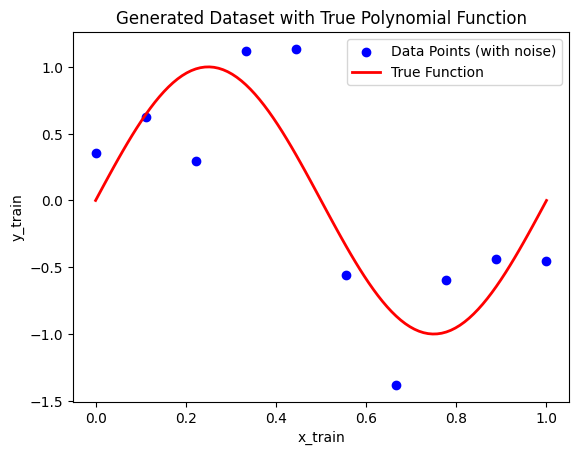

In [145]:
#creating dataset
def dataset(sample_size,std,domain=[0,1]):
    x = np.linspace(domain[0], domain[1], sample_size)  # 100 points in the range [-1, 1]
    np.random.shuffle(x)
    y= np.sin(2*np.pi*x) + np.random.normal(scale=std, size=x.shape)
    return x,y

# Define the true cubic function with noise
x_train,y_train=dataset(10,0.25)
x_test = np.linspace(0,1,100)
y_test = np.sin(2*np.pi*x_test)


# Plot the generated data points and the true function
plt.scatter(x_train, y_train, label='Data Points (with noise)', color='blue')
plt.plot(x_test, y_test, label='True Function', color='red', linewidth=2)
plt.title('Generated Dataset with True Polynomial Function')
plt.xlabel('x_train')
plt.ylabel('y_train')
plt.legend()
plt.show()


Transform x to polynomial features of degree 9 (M=9)

In [146]:

degree = 10
x_test = x_test[:,None]
x_test_polynomial = PolynomialFeature(degree).transform(x_test)
x_train = x_train[:, None]  # Reshape to a column vector
x_polynomial = PolynomialFeature(degree).transform(x_train)

# Display the shape of the transformed input
print(f'Shape of original x: {x_train.shape}')
print(f'Shape of x_polynomial (degree={degree}): {x_polynomial.shape}')


Shape of original x: (10, 1)
Shape of x_polynomial (degree=10): (10, 11)


In [147]:
x_tensor = torch.tensor(x_polynomial, dtype=torch.float32)  # Input features
y_tensor = torch.tensor(y_train, dtype=torch.float32) 
x_test_tensor=torch.tensor(x_test_polynomial,dtype=torch.float32)
y_test_tensor = torch.tensor(y_test,dtype=torch.float32)

In [148]:
x_tensor.shape

torch.Size([10, 11])

In [149]:
x_test_tensor.shape

torch.Size([100, 11])

In [150]:
features= x_tensor.shape[1]
weights=torch.zeros(features ,dtype=torch.float32, requires_grad=True)

Defining Loss function as defined earlier along with regularisation term to address overfitting

In [151]:
def loss_func(y_pred,y_ten,weights,lambda_regularisation=0.1):
    b= torch.sum(weights**2)
    c= (lambda_regularisation )/2 
    a=(y_pred - y_ten)**2
    return a/2 + c * b

To understand the effect creating Loss function without regularisation as well

In [152]:
def loss_func_without_reg(y_pred,y_ten,weights):
    return torch.sum((y_pred-y_ten)**2)

$$
\text{weight gradient} = (\hat{y} - y[i]) \cdot x[i] + \lambda \cdot w
$$

$$
\text{bias gradient} = (\hat{y} - y[i])
$$

$$
w = w - \eta \cdot \text{weight gradient}
$$

$$
b = b - \eta \cdot \text{bias gradient}
$$




In [153]:
def program(lambda_regularisation,learning_rate,x_tensor,y_tensor,all_epochs=1000):
    weights=torch.zeros(features ,dtype=torch.float32, requires_grad=True)
    bias = torch.zeros(1, dtype=torch.float32, requires_grad=True)
    all_loss=[]
    
    for epoch in range(all_epochs):
        total_loss=0
        for i in range(x_tensor.shape[0]):
            y_pred = torch.dot(x_tensor[i], weights) + bias 
            loss= loss_func(y_pred,y_tensor[i],weights,lambda_regularisation)
            grad_loss_weights= (y_pred-y_tensor[i]) * x_tensor[i] + lambda_regularisation * weights 
            grad_loss_bias = (y_pred-y_tensor[i])
            weights = weights - learning_rate* grad_loss_weights
            bias = bias - learning_rate* grad_loss_bias
            total_loss+=loss.item()
        # print(loss)
        all_loss.append(loss.item())
    return all_loss,weights,bias
   
        

In [154]:
la=0.01
lr=0.01
loss_with_regularisation,weights_with_reg,bias_with_reg= program (la,lr,x_tensor,y_tensor)

In [155]:
# calc weights without regularsation 
weights_without_reg=torch.zeros(features ,dtype=torch.float32, requires_grad=True)
bias_without_reg = torch.zeros(1, dtype=torch.float32, requires_grad=True)
learning_rate=0.01
loss_without_regularisation=[]
for epoch in range(1000):
    total_loss=0
    for i in range(x_tensor.shape[0]):
        y_pred= torch.dot(x_tensor[i],weights_without_reg)+bias_without_reg
        loss= loss_func_without_reg(y_pred,y_tensor[i],weights_without_reg)
        grad_loss_weight= (y_pred-y_tensor[i]) * x_tensor[i] 
        gard_loss_bais = (y_pred-y_tensor[i])
        weights_without_reg = weights_without_reg - learning_rate* grad_loss_weight
        bias_without_reg = bias_without_reg - learning_rate * gard_loss_bais 
        total_loss+=(loss.item())
    loss_without_regularisation.append(total_loss)

    # print(loss.item())

In [156]:
#loss_with_regularisation

In [157]:
learning_rate = 0.1
loss_values=[]
beta = 0.7
num_epochs = 1000
lambda_reg = 0.01  # Regularization parameter
num_samples = x_tensor.shape[0]
num_features = x_tensor.shape[1]

# Momentum SGD

The predicted value is given by:

$$
\hat{y} = x \cdot w + b
$$

The loss function with L2 regularization is defined as:

$$
L = \frac{1}{2}(\hat{y} - y)^2 + \lambda \cdot ||w||^2
$$

The gradients are computed as follows:

- Gradient of Loss with respect to Weights:

$$
\frac{\partial L}{\partial w} = (\hat{y} - y) \cdot x +  \lambda \cdot w
$$

- Gradient of Loss with respect to Bias:

$$
\frac{\partial L}{\partial b} = (\hat{y} - y)
$$

The update of velocities is done as follows:

- Velocity for Weights:

$$
v_w = \beta \cdot v_w + (1 - \beta) \cdot \frac{\partial L}{\partial w}
$$

- Velocity for Bias:

$$
v_b = \beta \cdot v_b + (1 - \beta) \cdot \frac{\partial L}{\partial b}
$$

The weights and bias are updated as:

- Update Weights:

$$
w = w - \eta \cdot v_w
$$

- Update Bias:

$$
b = b - \eta \cdot v_b
$$

**Where:**
- $( \eta )$ is the learning rate.
- $( \lambda )$ is the regularization constant.
- $( \beta )$ is the momentum factor.
- $( v_w )$ and $( v_b )$ are the velocities for weights and bias, respectively.




In [158]:

def momentum_program(x_tensor,y_tensor,lambda_reg, beta):
    weights = torch.zeros(num_features, dtype=torch.float32, requires_grad=True)
    bias = torch.zeros(1, dtype=torch.float32, requires_grad=True)
    velocity_w = torch.zeros(num_features, dtype=torch.float32)  # Velocity for weights
    velocity_b = torch.zeros(1, dtype=torch.float32)  # Velocity for bias
                         
    loss_values = []
    for epoch in range(num_epochs):
        total_loss=0
        for i in range(num_samples):
            func_value = torch.matmul(x_tensor[i], weights) +bias
            y_pred = func_value 
            loss=loss_func(y_pred,y_tensor[i],weights,lambda_reg)
            total_loss+=loss.item()
            
            # Compute gradients
            grad_loss_wrt_weight = (y_pred - y_tensor[i]) * x_tensor[i] + lambda_reg * weights
            grad_loss_wrt_bias = (y_pred - y_tensor[i])
    
            velocity_w = beta * velocity_w + (1-beta)* grad_loss_wrt_weight
            velocity_b = beta * velocity_b + (1-beta)* grad_loss_wrt_bias
            
        
            weights = weights - learning_rate * velocity_w # Update weights
            bias = bias -learning_rate * velocity_b # Update bias
        
        loss_values.append(total_loss/num_samples)
    return loss_values,weights,bias



## Hyperparamaters used : Lambda, Beta

beta value :0.9, la value is :0.01
beta value :0.9, la value is :0.02
beta value :0.9, la value is :0.03
beta value :0.9, la value is :0.04
beta value :0.9, la value is :0.05
beta value :0.9, la value is :0.060000000000000005
beta value :0.9, la value is :0.07
beta value :0.9, la value is :0.08
beta value :0.9, la value is :0.09
beta value :0.9, la value is :0.09999999999999999


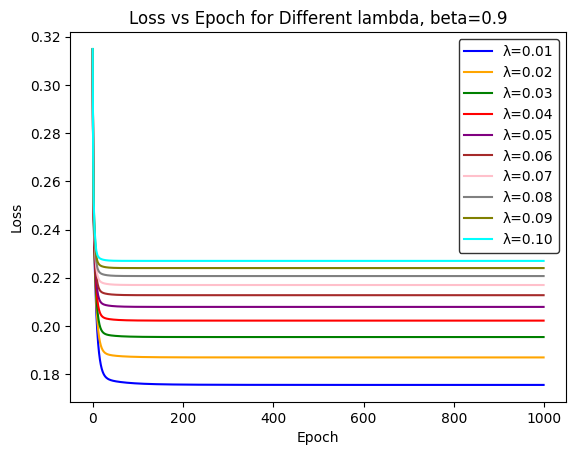

In [159]:
#for differnt value oflambda, same beta
la=0.01
beta=0.9
col=0
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
while la<0.1:
    print("beta value :{}, la value is :{}".format(beta,la))
    loss_values_with_momentum,weights_with_momentum,bias_with_momentum = momentum_program(x_tensor,y_tensor,la,beta)
    plt.plot(loss_values_with_momentum,color=colors[col % len(colors)],label=f'λ={la:.2f}')
    
    col+=1
    la+=0.01
plt.title(f'Loss vs Epoch for Different lambda, beta={beta}')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Customize the legend with a box around it
plt.legend(loc='best', frameon=True, edgecolor='black')  # Adds a box with black edges

plt.show()

lambda value :0.01, beta value is :0.1
lambda value :0.01, beta value is :0.2
lambda value :0.01, beta value is :0.30000000000000004
lambda value :0.01, beta value is :0.4
lambda value :0.01, beta value is :0.5
lambda value :0.01, beta value is :0.6
lambda value :0.01, beta value is :0.7
lambda value :0.01, beta value is :0.7999999999999999
lambda value :0.01, beta value is :0.8999999999999999


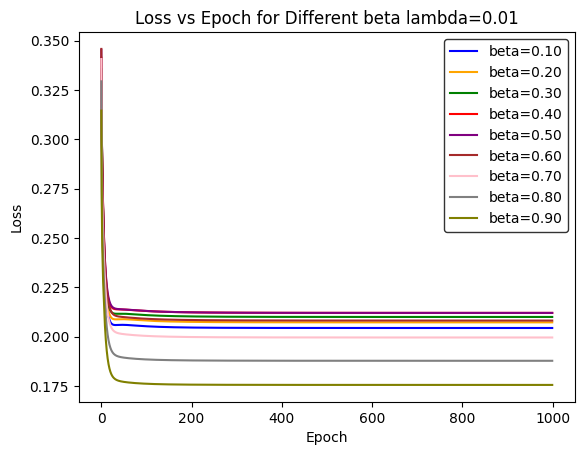

In [160]:
#for differnt value oflambda, leanring rate 
la=0.01
beta=0.1
col=0
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
while beta<=0.9:
    print("lambda value :{}, beta value is :{}".format(la,beta))
    loss_values_with_momentum,weights_with_momentum,bias_with_momentum = momentum_program(x_tensor,y_tensor,la,beta)
    plt.plot(loss_values_with_momentum,color=colors[col % len(colors)],label=f'beta={beta:.2f}')
    
    col+=1
    beta+=0.1
plt.title(f'Loss vs Epoch for Different beta lambda={la}')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Customize the legend with a box around it
plt.legend(loc='best', frameon=True, edgecolor='black')  # Adds a box with black edges

plt.show()

In [161]:
# based on above curves , getting values of hyper parameters la, lambda to get values
la=0.01
beta=0.9

loss_values_with_momentum,weights_with_momentum,bias_with_momentum = momentum_program(x_tensor,y_tensor,la,beta)


In [162]:
loss_values_with_momentum

[0.31451777555048466,
 0.2675189127214253,
 0.24602194559411145,
 0.23615926814964042,
 0.2278046200866811,
 0.22201592065393924,
 0.21619873852469026,
 0.21029477317351847,
 0.20549165548291057,
 0.20160964746028184,
 0.19821919542737304,
 0.19529431839473546,
 0.19283507163636388,
 0.19073205571621657,
 0.1889100811444223,
 0.18734281221404672,
 0.18599852724000812,
 0.18484082901850343,
 0.18384300339967014,
 0.18298388235270976,
 0.18224327052012085,
 0.1816035270690918,
 0.18105027228593826,
 0.18057116363197565,
 0.18015548968687653,
 0.17979413950815798,
 0.1794793468900025,
 0.1792045036330819,
 0.17896391917020082,
 0.1787526786327362,
 0.17856666212901473,
 0.1784022874198854,
 0.1782565014436841,
 0.17812670627608895,
 0.1780107024125755,
 0.17790651228278875,
 0.17781258448958398,
 0.17772745415568353,
 0.17764998162165285,
 0.17757912827655672,
 0.17751401327550412,
 0.17745388513430954,
 0.17739813067018986,
 0.17734616817906498,
 0.17729752361774445,
 0.17725182520225644

## Loss vs Epoch Plot:
$$
\text{Loss vs Epoch: MSE with Regularization Loss}
$$


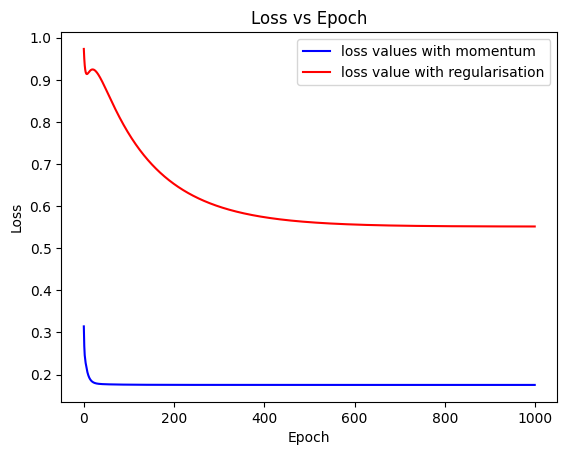

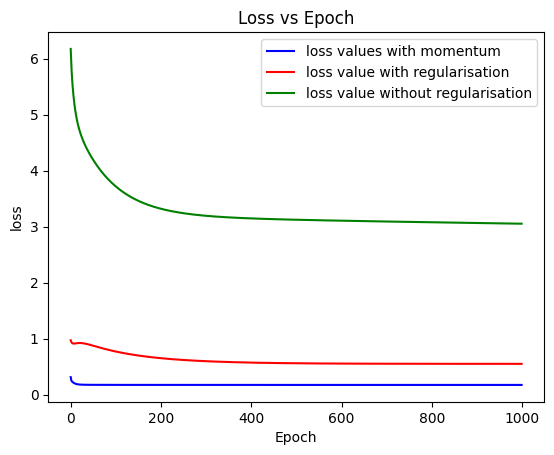

In [163]:
plt.plot(loss_values_with_momentum,color='blue',label='loss values with momentum')
plt.plot(loss_with_regularisation,color='red',label='loss value with regularisation')
# plt.plot(loss_without_regularisation,color='green',label='loss value without regularisation')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.plot(loss_values_with_momentum,color='blue',label='loss values with momentum')
plt.plot(loss_with_regularisation,color='red',label='loss value with regularisation')
plt.plot(loss_without_regularisation,color='green',label='loss value without regularisation')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

## Plotting true function , regularised , without regularised and Moment based convergence

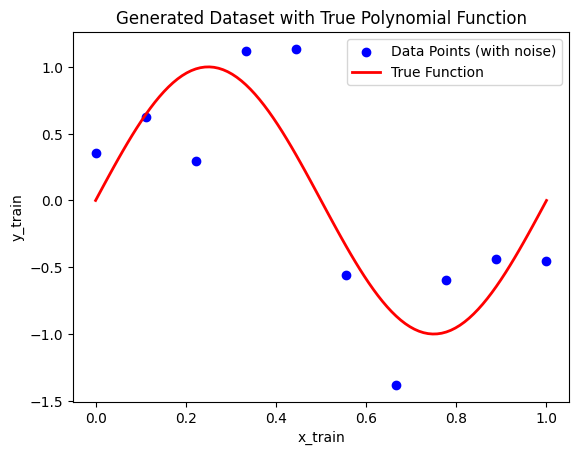

In [164]:
plt.scatter(x_train, y_train, label='Data Points (with noise)', color='blue')
plt.plot(x_test, y_test, label='True Function', color='red', linewidth=2)
plt.title('Generated Dataset with True Polynomial Function')
plt.xlabel('x_train')
plt.ylabel('y_train')
plt.legend()
plt.show()

In [165]:
y_pred_with_momentum = []
y_pred_without_reg=[]
y_pred_with_reg = []

for x in x_test_tensor:
    y_pred_with_momentum.append((torch.sum(x * weights_with_momentum)+bias_with_momentum).item())
    y_pred_without_reg.append((torch.sum(x *weights_without_reg)+bias_without_reg).item())
    y_pred_with_reg.append((torch.sum(x *weights_with_reg)+bias_with_reg).item())


In [166]:
y_pred_with_momentum_ = np.array(y_pred_with_momentum)
y_pred_without_reg_=np.array(y_pred_without_reg)
y_pred_with_reg_= np.array(y_pred_with_reg)

In [167]:
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)
print("y_pred_with_momentum size:", len(y_pred_with_momentum))
print("y_pred_with_reg size:", len(y_pred_with_reg))
print("y_test_pred_without_reg size:", len(y_pred_without_reg))


x_test shape: (100, 1)
y_test shape: (100,)
y_pred_with_momentum size: 100
y_pred_with_reg size: 100
y_test_pred_without_reg size: 100


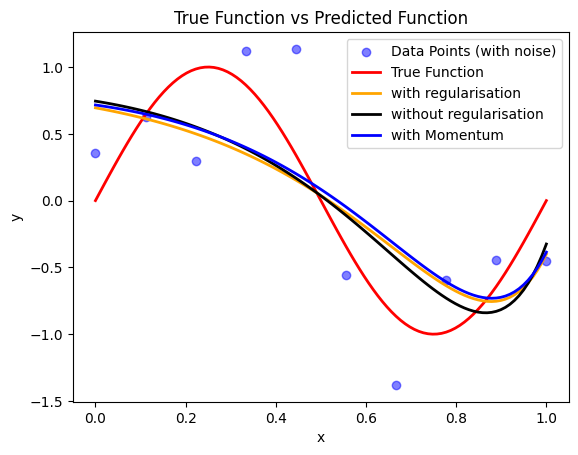

In [168]:
sorted_indices = np.argsort(x_test)
plt.scatter(x_train, y_train, label='Data Points (with noise)', color='blue', alpha=0.5)
plt.plot(x_test, y_test, label='True Function', color='red', linewidth=2)
plt.plot(x_test, y_pred_with_reg_, label='with regularisation', color='orange', linewidth=2)

plt.plot(x_test, y_pred_without_reg_, label='without regularisation', color='black', linewidth=2)

plt.plot(x_test, y_pred_with_momentum_, label='with Momentum', color='blue', linewidth=2)

plt.title('True Function vs Predicted Function')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()



## Hence , SGD with momentum redeuces loss and gets to better convergence value and least loss function value 
